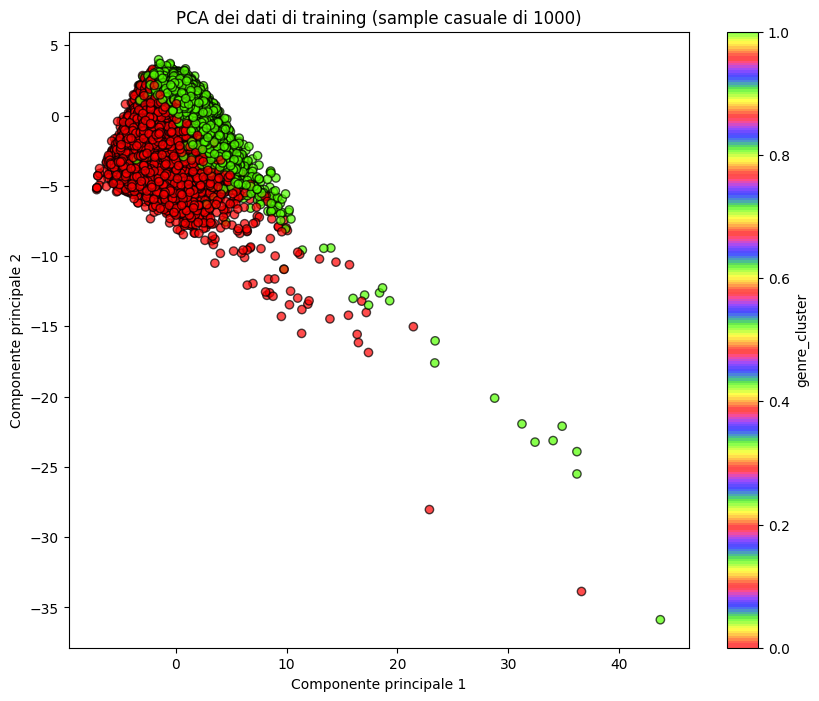

Accuracy del modello SVM: 1.00
Accuracy 0.9998125
F1-score [0.99976829 0.99984254]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       1.00      1.00      1.00      9525

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



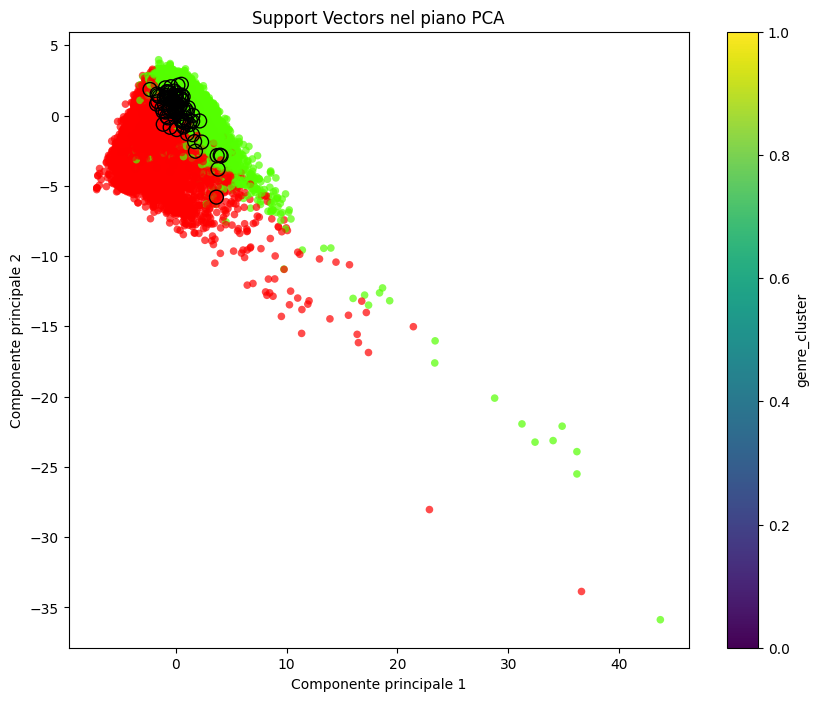

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Carica il dataset
df_track = pd.read_csv('tracks.csv', low_memory=False)

# Rimuovi righe con valori mancanti e duplicati
df_track.dropna(inplace=True)
df_track.drop_duplicates(subset='id', keep='first', inplace=True)

# Seleziona le colonne di interesse
columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'start_of_fade_out', 
           'n_beats']
df_sub = df_track[columns]

# Aggiungi una colonna per il genere "happy/sad"
df_track['genre_happy_sad'] = df_track['energy'].apply(lambda x: 1 if x > 0.6 else 0)

# Seleziona le features X e il target y
X = df_sub.values
y = df_track['genre_happy_sad'].values

# Prendi un sample casuale di 1000 dati
np.random.seed(42)  # Imposta il seed per riproducibilità
sample_indices = np.random.choice(len(X), size=80000, replace=False)
X_sample = X[sample_indices]
y_sample = y[sample_indices]

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=100, stratify=y_sample)

# Standardizza i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applica PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA dei dati di training
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.colorbar(label='genre_cluster')
plt.title('PCA dei dati di training (sample casuale di 1000)')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

# Addestra un modello SVM
svm = LinearSVC(random_state=100)
svm.fit(X_train, y_train)

# Valuta il modello
accuracy = svm.score(X_test, y_test)
print(f'Accuracy del modello SVM: {accuracy:.2f}')

# Esempio di ricerca grid search per ottimizzare C
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000]}
grid_search = GridSearchCV(LinearSVC(random_state=50), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Addestra e valuta il modello con il miglior parametro C trovato
clf = LinearSVC(C=best_params['C'], random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# Plot degli support vectors nel piano PCA
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.title('Support Vectors nel piano PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.colorbar(label='genre_cluster')
plt.show()


In [2]:
clf.__dict__

{'dual': 'auto',
 'tol': 0.0001,
 'C': 1000,
 'multi_class': 'ovr',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'verbose': 0,
 'random_state': 42,
 'max_iter': 1000,
 'penalty': 'l2',
 'loss': 'squared_hinge',
 'n_features_in_': 13,
 'classes_': array([0, 1], dtype=int64),
 'coef_': array([[-3.69239282e-01, -4.02275345e-03,  3.86205600e-03,
          9.80718144e+01,  2.78542034e-02,  4.08202231e-02,
         -9.68576236e-03, -1.14153613e-02,  2.03367895e-02,
          4.35500696e-02, -4.42512264e-02,  2.74450921e-01,
          1.70013961e-01]]),
 'intercept_': array([13.16305345]),
 'n_iter_': 14}

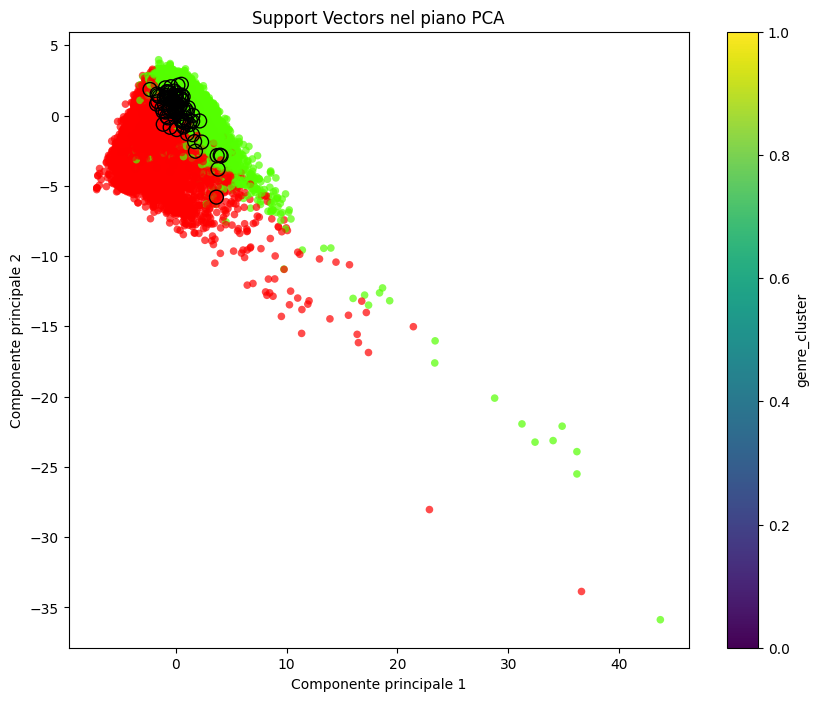

In [3]:
# Plot degli support vectors nel piano PCA
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.title('Support Vectors nel piano PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.colorbar(label='genre_cluster')
plt.show()

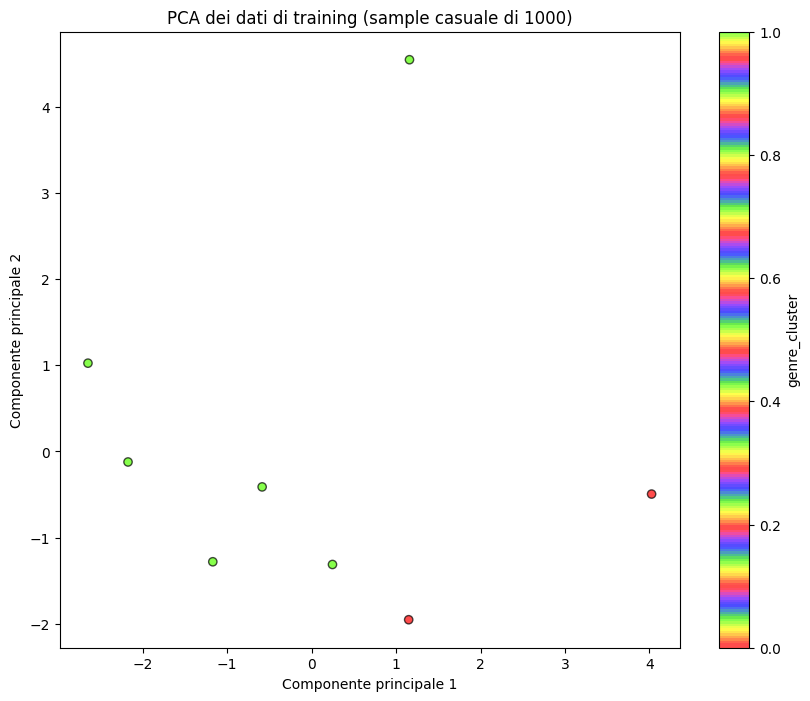

Accuracy del modello SVM: 1.00
Accuracy 1.0
F1-score [1.]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


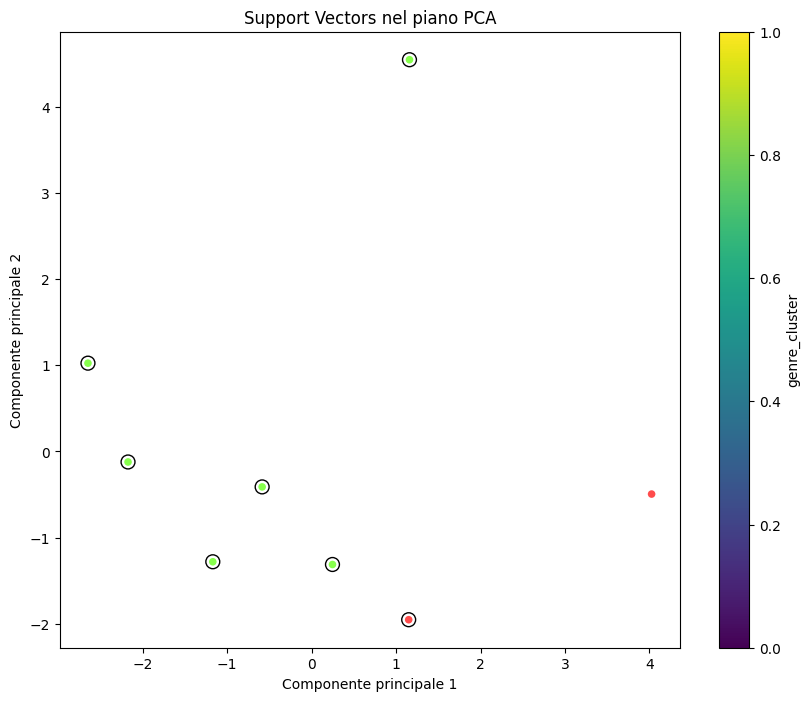

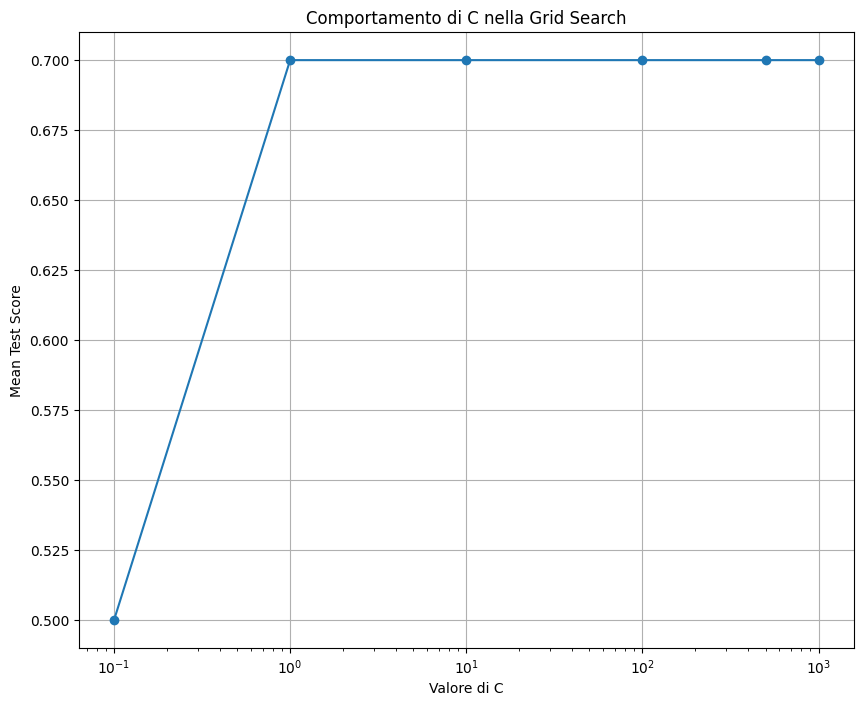

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Carica il dataset
df_track = pd.read_csv('tracks.csv', low_memory=False)

# Rimuovi righe con valori mancanti e duplicati
df_track.dropna(inplace=True)
df_track.drop_duplicates(subset='id', keep='first', inplace=True)

# Seleziona le colonne di interesse
columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'start_of_fade_out', 
           'n_beats']
df_sub = df_track[columns]

# Aggiungi una colonna per il genere "happy/sad"
df_track['genre_happy_sad'] = df_track['energy'].apply(lambda x: 1 if x > 0.6 else 0)

# Seleziona le features X e il target y
X = df_sub.values
y = df_track['genre_happy_sad'].values

# Prendi un sample casuale di 10 dati
np.random.seed(42)  # Imposta il seed per riproducibilità
sample_indices = np.random.choice(len(X), size=10, replace=False)
X_sample = X[sample_indices]
y_sample = y[sample_indices]

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=100, stratify=y_sample)

# Standardizza i dati
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applica PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA dei dati di training
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.colorbar(label='genre_cluster')
plt.title('PCA dei dati di training (sample casuale di 10)')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.show()

# Addestra un modello SVM
svm = LinearSVC(random_state=50)
svm.fit(X_train, y_train)

# Valuta il modello
accuracy = svm.score(X_test, y_test)
print(f'Accuracy del modello SVM: {accuracy:.2f}')

# Esempio di ricerca grid search per ottimizzare C
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000]}
grid_search = GridSearchCV(LinearSVC(random_state=100), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Addestra e valuta il modello con il miglior parametro C trovato
clf = LinearSVC(C=best_params['C'], random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# Plot degli support vectors nel piano PCA
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.title('Support Vectors nel piano PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.colorbar(label='genre_cluster')
plt.show()

# Visualizza i risultati della Grid Search
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 8))
plt.plot(results['param_C'], results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Valore di C')
plt.ylabel('Mean Test Score')
plt.title('Comportamento di C nella Grid Search')
plt.grid(True)
plt.show()


La parte degli iperparametri è quella che utilizza GridSearchCV per trovare i migliori valori per i parametri del modello. Questo processo di ricerca ottimizza i parametri di un modello (in questo caso, C per LinearSVC) per migliorare la performance predittiva. Ecco i passaggi dettagliati e il codice corrispondente per effettuare la ricerca degli iperparametri:

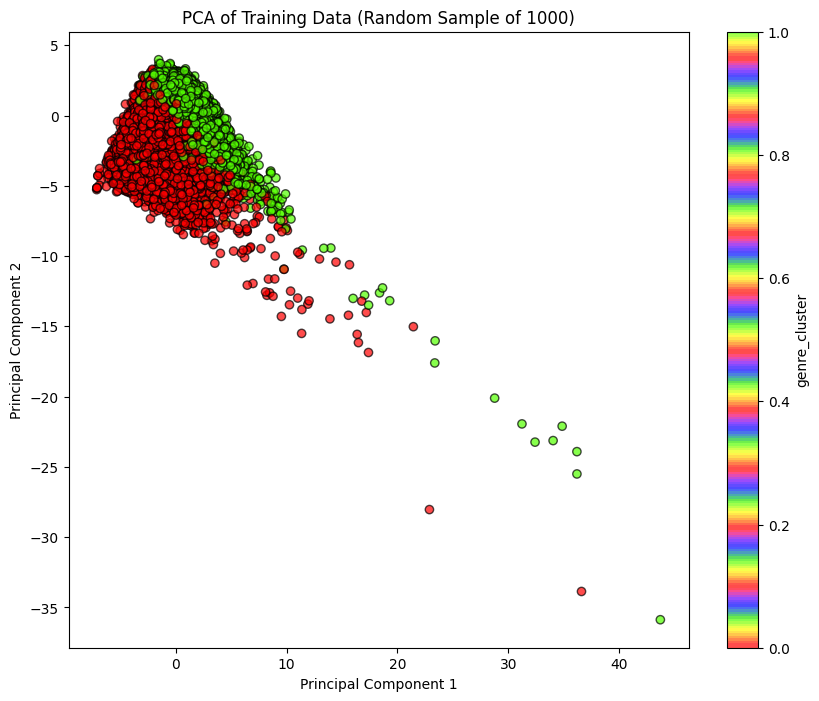

Accuracy of the SVM model: 1.00
Best parameters found: {'C': 1000}
Accuracy: 0.9998125
F1-score: [0.99976829 0.99984254]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6475
           1       1.00      1.00      1.00      9525

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



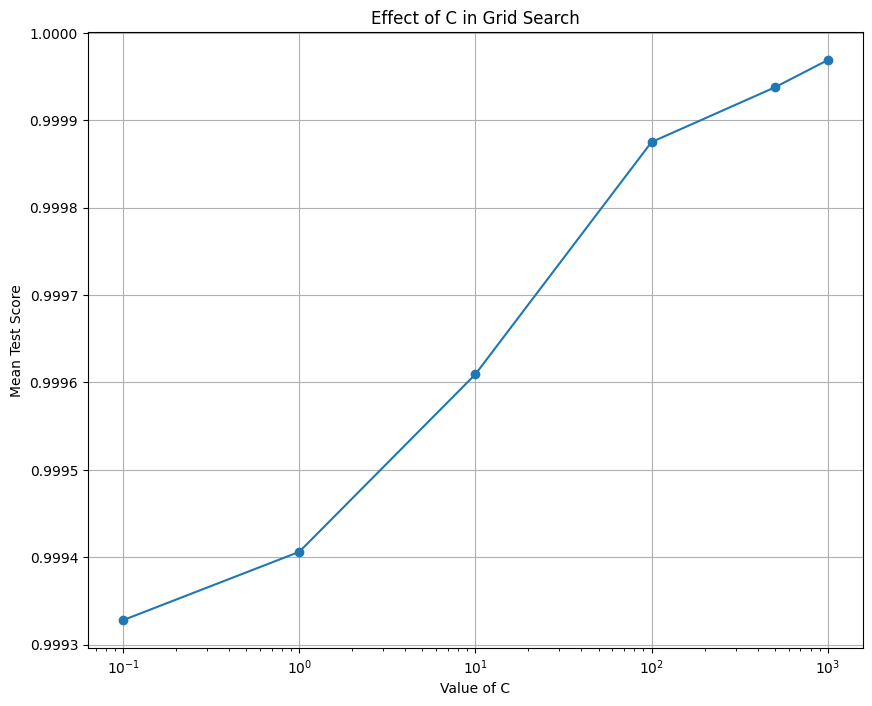

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
# Load the dataset
df_track = pd.read_csv('tracks.csv', low_memory=False)

# Remove rows with missing values and duplicates
df_track.dropna(inplace=True)
df_track.drop_duplicates(subset='id', keep='first', inplace=True)

# Select columns of interest
columns = ['duration_ms', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'start_of_fade_out', 
           'n_beats']
df_sub = df_track[columns]

# Add a column for the genre "happy/sad"
df_track['genre_happy_sad'] = df_track['energy'].apply(lambda x: 1 if x > 0.6 else 0)

# Select features X and target y
X = df_sub.values
y = df_track['genre_happy_sad'].values

# Take a random sample of 80000 data points
np.random.seed(42)  # Set seed for reproducibility
sample_indices = np.random.choice(len(X), size=80000, replace=False)
X_sample = X[sample_indices]
y_sample = y[sample_indices]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=100, stratify=y_sample)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA of training data
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.colorbar(label='genre_cluster')
plt.title('PCA of Training Data (Random Sample of 80000)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
# Train an SVM model
svm = LinearSVC(random_state=100)
svm.fit(X_train, y_train)

# Evaluate the model
accuracy = svm.score(X_test, y_test)
print(f'Accuracy of the SVM model: {accuracy:.2f}')
# Define parameter grid for C
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000]}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(LinearSVC(random_state=50), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters found: {best_params}')
# Train the best model
clf = LinearSVC(C=best_params['C'], random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate the best model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred))
# Visualize Grid Search results
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 8))
plt.plot(results['param_C'], results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Value of C')
plt.ylabel('Mean Test Score')
plt.title('Effect of C in Grid Search')
plt.grid(True)
plt.show()
